<a href="https://colab.research.google.com/github/savinthie/Final_Year_Project_IDP_2024-2025/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, ReLU, Concatenate, MaxPooling1D,Dropout
from tensorflow.keras.optimizers import Adam
import joblib
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping


In [2]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/FYP 2024 25/USDataset.csv', header=1)
df = df.fillna(0)

Mounted at /content/drive


In [3]:
# Data Preprocessing
df.columns = [col.lower().replace(' ', '').replace('.', '') for col in df.columns]
cols_to_keep = ['stateabv', 'county', 'family', 'housing', 'food', 'transportation',
                'healthcare', 'othernecessities', 'childcare', 'taxes', 'total',
                'median_family_income', 'num_counties_in_st']
df1 = df[cols_to_keep].copy()

df1['median_family_income'] = df1['median_family_income'].replace(',', '', regex=True).astype(float)

In [4]:
# Feature Engineering
df1['n_parents'] = df1['family'].str.slice(0, 1).astype(int)
df1['n_children'] = df1['family'].str.slice(2, 3).astype(int)
df1['n_members'] = df1['n_parents'] + df1['n_children']
df1['financial_stability'] = df1['median_family_income'] / df1['total']
df1["per_member_cost"] = df1["total"] / df1["n_members"]
df1["child_expense_cost"] = df1["per_member_cost"]*df1["n_children"]
df1["parent_expense_cost"] = df1["per_member_cost"]*df1["n_parents"]
df1["other_expense_cost"] = df1["total"] - (df1["child_expense_cost"]+df1["parent_expense_cost"])

In [5]:
# Splitting the data
X = df1[['total', 'median_family_income', 'num_counties_in_st', 'n_children', 'n_parents', 'n_members']+['per_member_cost','child_expense_cost','parent_expense_cost','other_expense_cost']].values
y_expenses = df1[['housing', 'food', 'transportation', 'healthcare', 'othernecessities', 'childcare', 'taxes']].values

target_col_list = ['housing', 'food', 'transportation', 'healthcare', 'othernecessities', 'childcare', 'taxes']

# Scaling
scaler_X = StandardScaler()

# Load the X scaler
# scaler_X = joblib.load('scaler_X.pkl')

X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()

# Load the y scaler
# scaler_y = joblib.load('scaler_y.pkl')
y_exp_scaled = scaler_y.fit_transform(y_expenses)



# Save the X scaler
joblib.dump(scaler_X, 'scaler_X.pkl')

# Save the y scaler
joblib.dump(scaler_y, 'scaler_y.pkl')

['scaler_y.pkl']

In [6]:
# Cross-Validation Setup
kf = KFold(n_splits=5, shuffle=True, random_state=100)

Fold 1/5
Training model for Housing...
Train Data: {'MAE': 0.07516859551876486, 'MSE': 0.009841751532452817, 'RMSE': 0.09920560232392532, 'R-Squared': 0.9872967448185954, 'MAPE': 74.114098420328}
Validation Data: {'MAE': 0.33760885677489744, 'MSE': 0.2674379094491593, 'RMSE': 0.5171439929547276, 'R-Squared': 0.8516514926166674, 'MAPE': 118.18501809545998}
Test Data: {'MAE': 0.3306313672384916, 'MSE': 0.25669239653164283, 'RMSE': 0.5066481979950613, 'R-Squared': 0.8551658955274746, 'MAPE': 127.65873241624884}

Training model for Food...
Train Data: {'MAE': 0.04653633141929446, 'MSE': 0.0038966227038716504, 'RMSE': 0.06242293411777158, 'R-Squared': 0.9959440245949178, 'MAPE': 25.173667288327856}
Validation Data: {'MAE': 0.19213968813003215, 'MSE': 0.08387169509250651, 'RMSE': 0.28960610334125647, 'R-Squared': 0.9275975674125269, 'MAPE': 94.83317018291217}
Test Data: {'MAE': 0.1893883345818566, 'MSE': 0.07843666674742002, 'RMSE': 0.2800654686808426, 'R-Squared': 0.9303682711252499, 'MAPE'

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


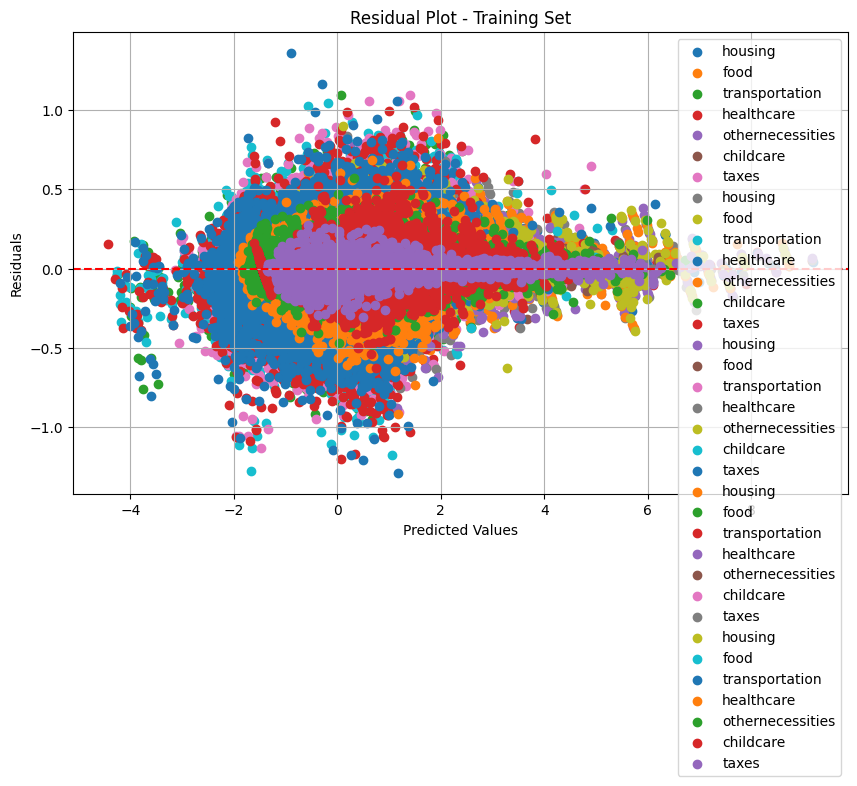

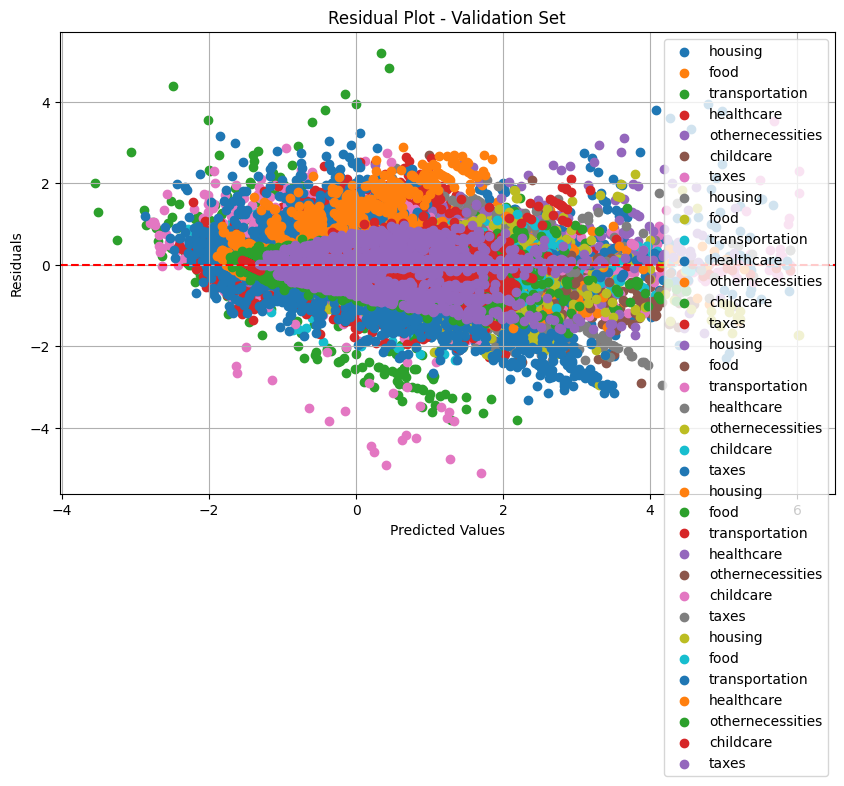

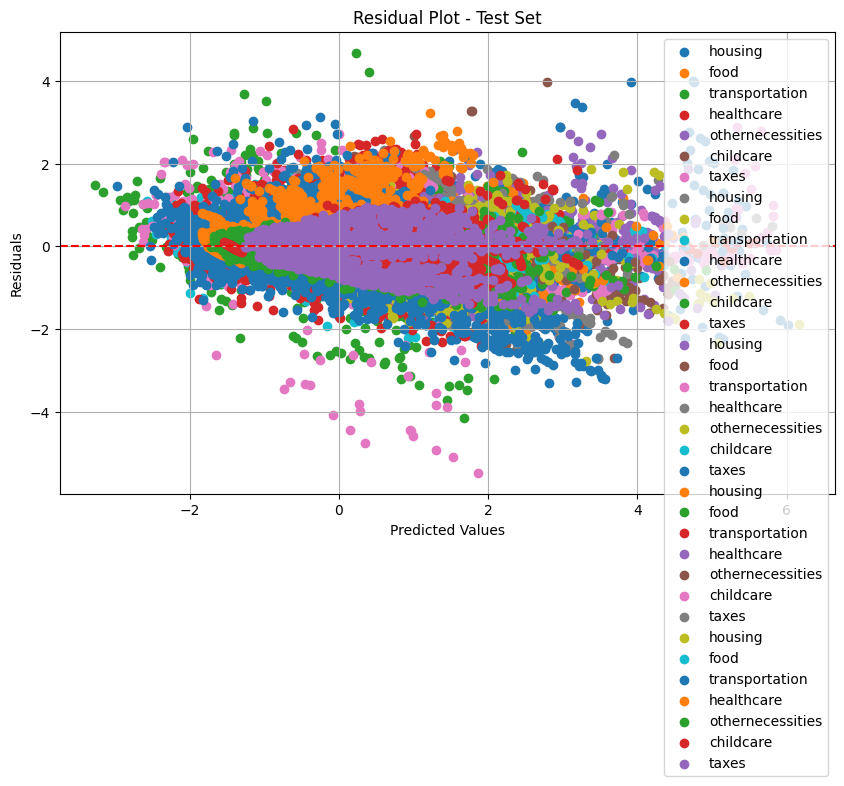

In [7]:
#xgboost
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Cross-Validation with Evaluation and Training/Validation Loss Curve
def cross_val_with_evaluation(X_scaled, y_exp_scaled, kf, target_col_list):
    fold = 1

    # To store metrics across all folds
    metrics_summary = {target: {'train': [], 'val': [], 'test': []} for target in target_col_list}

    # Store predictions for plotting residuals later
    all_train_preds = []
    all_val_preds = []
    all_test_preds = []

    # Store actual values for plotting residuals later
    all_train_actuals = []
    all_val_actuals = []
    all_test_actuals = []

    for train_index, val_index in kf.split(X_scaled):
        print(f"Fold {fold}/{kf.get_n_splits()}")
        X_train, X_val = X_scaled[train_index], X_scaled[val_index]
        y_train, y_val = y_exp_scaled[train_index], y_exp_scaled[val_index]

        # 50/50 split of remaining data for test set
        X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=100)

        # Initialize metrics storage for this fold
        fold_train_metrics = {target: [] for target in target_col_list}
        fold_val_metrics = {target: [] for target in target_col_list}
        fold_test_metrics = {target: [] for target in target_col_list}

        # Store predictions for residual plots
        fold_train_preds = []
        fold_val_preds = []
        fold_test_preds = []

        # Train and evaluate for each target variable separately
        for i, target in enumerate(target_col_list):
            print(f"Training model for {target.capitalize()}...")

            # Create and fit the XGBoost model
            model = xgb.XGBRegressor(
                objective='reg:squarederror',
                n_estimators=1000,
                learning_rate=0.1,
                max_depth=6,
                min_child_weight=1,
                subsample=0.8,
                colsample_bytree=0.8,
                gamma=0,
                reg_alpha=0.1,
                reg_lambda=1.0,
                random_state=42  # Set random state for reproducibility
            )

            model.fit(X_train, y_train[:, i])  # Fit model on the specific target

            # Predictions
            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)
            y_test_pred = model.predict(X_test)

            # Store predictions and actual values for residual plots
            fold_train_preds.append(y_train_pred)
            fold_val_preds.append(y_val_pred)
            fold_test_preds.append(y_test_pred)

            # Calculate metrics for this target
            train_metrics = calculate_metrics(y_train[:, i], y_train_pred)
            val_metrics = calculate_metrics(y_val[:, i], y_val_pred)
            test_metrics = calculate_metrics(y_test[:, i], y_test_pred)

            # Store metrics for this fold
            fold_train_metrics[target].append(train_metrics)
            fold_val_metrics[target].append(val_metrics)
            fold_test_metrics[target].append(test_metrics)

            print('Train Data:', train_metrics)
            print('Validation Data:', val_metrics)
            print('Test Data:', test_metrics)
            print()

        # Append predictions to the overall lists
        all_train_preds.append(fold_train_preds)
        all_val_preds.append(fold_val_preds)
        all_test_preds.append(fold_test_preds)

        all_train_actuals.append(y_train)
        all_val_actuals.append(y_val)
        all_test_actuals.append(y_test)

        # Store metrics summary across folds
        for target in target_col_list:
            metrics_summary[target]['train'].append(fold_train_metrics[target])
            metrics_summary[target]['val'].append(fold_val_metrics[target])
            metrics_summary[target]['test'].append(fold_test_metrics[target])

        fold += 1

    # Compute and display final average metrics across all folds
    print("Final Average Metrics After Cross-Validation:")
    for target in target_col_list:
        print(f"Results for {target.capitalize()}:")

        avg_train_metrics = average_metrics(metrics_summary[target]['train'])
        avg_val_metrics = average_metrics(metrics_summary[target]['val'])
        avg_test_metrics = average_metrics(metrics_summary[target]['test'])

        print("Average Train Metrics:", avg_train_metrics)
        print("Average Validation Metrics:", avg_val_metrics)
        print("Average Test Metrics:", avg_test_metrics)
        print()

    # Plot residuals for train, validation, and test sets
    plot_residuals(all_train_actuals, all_train_preds, 'Training Set')
    plot_residuals(all_val_actuals, all_val_preds, 'Validation Set')
    plot_residuals(all_test_actuals, all_test_preds, 'Test Set')

    return model

def calculate_metrics(y_true, y_pred):
    """Calculate regression metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R-Squared': r2, 'MAPE': mape}

def average_metrics(metrics_list):
    """Compute the average of the metrics."""
    # Convert list of lists of dictionaries to a list of dictionaries
    metrics_list = [d[0] for d in metrics_list]  # Extract the dictionary from each inner list

    # Convert list of dictionaries to a single dictionary with lists as values
    metrics_dict = {key: [d[key] for d in metrics_list] for key in metrics_list[0]}
    # Calculate the mean of each metric
    avg_metrics = {key: np.mean(value) for key, value in metrics_dict.items()}
    return avg_metrics

def plot_residuals(actual_values_list, predicted_values_list, title):
    """Plot residuals."""
    plt.figure(figsize=(10, 6))

    for actual_values, predicted_values_fold in zip(actual_values_list, predicted_values_list):
        for i in range(len(target_col_list)):  # Loop through target variables
            predicted_values = predicted_values_fold[i]  # Get predictions for the current target
            residuals = actual_values[:, i] - predicted_values  # Calculate residuals for the current target
            plt.scatter(predicted_values, residuals, label=target_col_list[i])  # Plot with label

    plt.axhline(0, color='red', linestyle='--')  # Line at zero residual
    plt.title(f'Residual Plot - {title}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend()  # Show legend for target variables
    plt.grid(True)
    plt.show()

# Cross-Validation Execution
kf = KFold(n_splits=5)  # Define your KFold object here
model = cross_val_with_evaluation(X_scaled, y_exp_scaled, kf, target_col_list)  # Ensure target_col_list is defined


In [8]:
def get_prediction(model, input_data):
    input_data_val = input_data.values
    input_data_val_scaled = scaler_X.fit_transform(input_data_val)
    input_data_val_scaled = input_data_val_scaled[..., np.newaxis]
    input_data_pred = np.column_stack(model.predict(input_data_val_scaled))
    input_data_pred_original = scaler_y.inverse_transform(input_data_pred)
    return input_data_pred_original

In [9]:
input_data = pd.DataFrame(
              [[7000,40000, 50, 2, 0, 1]],
              columns=['total', 'median_family_income', 'num_counties_in_st', 'n_children', 'n_parents', 'n_members']
        )

input_data["per_member_cost"] = input_data["total"] / input_data["n_members"]
input_data["child_expense_cost"] = input_data["per_member_cost"]*input_data["n_children"]
input_data["parent_expense_cost"] = input_data["per_member_cost"]*input_data["n_parents"]
input_data["other_expense_cost"] = input_data["total"] - (input_data["child_expense_cost"]+input_data["parent_expense_cost"])